## XModalix Workbook

#### IMPORTS

In [1]:
import os
from autoencodix.configs.default_config import DataConfig, DataInfo, DefaultConfig
from autoencodix.configs.xmodalix_config import XModalixConfig
import autoencodix as acx

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
print(notebook_dir)
os.chdir(notebook_dir)
os.chdir("..")
print(os.getcwd())


/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/maximilianjoas/development/autoencodix_package/notebooks
/Users/maximilianjoas/development/autoencodix_package


#### GLOBALS
**ATTENTION**
Be sure to have the appropriate files, or adjust paths and make your own config

In [2]:
IMGROOT = os.path.join("data/images/ALY-2_SYS721/")
IMGMAPPING = os.path.join("data/ALY-2_SYS721_mappings.txt")
NUMFILE = os.path.join("data/AM3_NO2_raw_cell.tsv")

img_config = DefaultConfig(
    checkpoint_interval=25,
	loss_reduction = "sum",
    class_param="early",
    epochs=5,
	beta = 0.01,
	gamma= 2,
	delta_class= 0.0,
	delta_pair = 3,
	learning_rate=0.001,
	k_filter=1000,
	latent_dim=8,
    batch_size=181,
    # blablabla="",
    data_config=DataConfig(
        data_info={
            "IMG": DataInfo(
                file_path=IMGROOT,
                data_type="IMG",
				scaling="MINMAX",
                translate_direction="to",
                pretrain_epochs=30
            ),
            "RNA": DataInfo(
                file_path=NUMFILE,
                data_type="NUMERIC",
				scaling = "MINMAX",
                translate_direction="from",
            ),
            "RNA2": DataInfo(
                file_path=NUMFILE,
                data_type="NUMERIC",
            ),
            "ANNO": DataInfo(
                file_path=IMGMAPPING,
                data_type="ANNOTATION",
            ),
        },
    ),
)

### Run Xmodalix with defined config
- .run() does not work yet, because we dont have a visualizer, so we run it step by step

In [3]:
%env CUBLAS_WORKSPACE_CONFIG=:16:8

env: CUBLAS_WORKSPACE_CONFIG=:16:8


In [4]:
xmodalix = acx.XModalix(config=img_config)
xmodalix.preprocess()
xmodalix.fit()
result = xmodalix.predict()

preprocessing
Checking data type: IMG
Found image type in config
current data info: file_path='data/images/ALY-2_SYS721/' data_type='IMG' scaling='MINMAX' filtering='VAR' sep=None extra_anno_file=None is_single_cell=False min_cells=0.05 min_genes=0.02 selected_layers=['X'] is_X=False normalize_counts=True log_transform=True k_filter=20 img_root=None img_width_resize=64 img_height_resize=64 translate_direction='to' pretrain_epochs=30
Checking data type: RNA
Checking data type: RNA2
Checking data type: ANNO
Given image size is possible, rescaling images to: 64x64
reading annotation file: data/ALY-2_SYS721_mappings.txt
Successfully loaded 260 images for IMG
--- Running Pairing-Aware Split ---
Identified 260 fully paired samples across all modalities.
Identified 0 samples present in at least one, but not all, modalities.
Successfully generated synchronized indices for all modalities.
Converting 182 images to torch.float32 tensors...
Converting 52 images to torch.float32 tensors...
Converti

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/base/_base_pipeline.py:181: UserWarning: Your config is of type: <class 'autoencodix.configs.default_config.DefaultConfig'>, for this pipeline the default params of: <class 'autoencodix.configs.xmodalix_config.XModalixConfig'> work best
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_imgreader.py:251: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  annotation = pd.read_csv(anno_file, sep=sep)
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/data/_filter.py:96: UserWarning: WARNING: k is None or greater than number of columns, keeping all features.
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/data/_filter.py:96: UserWarning: WARNING: k is None or greater than number of col

Check if we need to pretrain: multi_bulk.RNA
pretrain epochs : 0
No pretraining for multi_bulk.RNA
Check if we need to pretrain: multi_bulk.RNA2
pretrain epochs : 0
No pretraining for multi_bulk.RNA2
Check if we need to pretrain: img.IMG
pretrain epochs : 30
Starting Pretraining for: img.IMG with <class 'autoencodix.trainers._general_trainer.GeneralTrainer'>


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/base/_base_trainer.py:104: UserWarning: increased batch_size to 182 for trainset, to avoid dropping samples and having batches (makes trainingdynamics messy with missing samples per epoch) of size one (fails for Models with BachNorm)
  warnings.warn(


Epoch 1 - Train Loss: 115561.7578
Sub-losses: recon_loss: 115561.7578, var_loss: 934.9722, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 13169.8262
Sub-losses: recon_loss: 13169.8262, var_loss: 0.5563, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 193030.4375
Sub-losses: recon_loss: 94811.3125, var_loss: 3972264192.0000, anneal_factor: 0.0025, effective_beta_factor: 0.0000
Epoch 2 - Valid Loss: 13125.7803
Sub-losses: recon_loss: 13125.7803, var_loss: 0.5586, anneal_factor: 0.0025, effective_beta_factor: 0.0000
Epoch 3 - Train Loss: 90308.8281
Sub-losses: recon_loss: 90214.6406, var_loss: 79014.1641, anneal_factor: 0.1192, effective_beta_factor: 0.0012
Epoch 3 - Valid Loss: 12993.9238
Sub-losses: recon_loss: 12993.9229, var_loss: 0.5593, anneal_factor: 0.1192, effective_beta_factor: 0.0012
Epoch 4 - Train Loss: 85267.6797
Sub-losses: recon_loss: 84619.9297, var_loss: 73541.0625, anneal_factor: 0.8808, effective_beta_factor: 0.008

### Loading and Saving XModalix
- works like for other pipelines too, can be used to run another predict pairing also

In [5]:
len(xmodalix._datasets.train.datasets["multi_bulk.RNA"])

182

In [6]:
loader = xmodalix._trainer._trainloader
for batch in loader:
    print(batch)
    break

[np.str_('T_6'), np.str_('T_240'), np.str_('T_207'), np.str_('T_88'), np.str_('T_76'), np.str_('T_68'), np.str_('T_106'), np.str_('T_160'), np.str_('T_198'), np.str_('T_247'), np.str_('T_129'), np.str_('T_83'), np.str_('T_149'), np.str_('T_113'), np.str_('T_154'), np.str_('T_131'), np.str_('T_20'), np.str_('T_172'), np.str_('T_93'), np.str_('T_45'), np.str_('T_85'), np.str_('T_26'), np.str_('T_22'), np.str_('T_100'), np.str_('T_163'), np.str_('T_166'), np.str_('T_175'), np.str_('T_157'), np.str_('T_10'), np.str_('T_65'), np.str_('T_257'), np.str_('T_200'), np.str_('T_69'), np.str_('T_80'), np.str_('T_183'), np.str_('T_223'), np.str_('T_70'), np.str_('T_187'), np.str_('T_130'), np.str_('T_178'), np.str_('T_114'), np.str_('T_98'), np.str_('T_87'), np.str_('T_111'), np.str_('T_254'), np.str_('T_39'), np.str_('T_206'), np.str_('T_184'), np.str_('T_144'), np.str_('T_156'), np.str_('T_128'), np.str_('T_227'), np.str_('T_73'), np.str_('T_57'), np.str_('T_199'), np.str_('T_164')]
{'multi_bulk.

In [7]:
f = next(iter(batch))
f

'multi_bulk.RNA'

In [8]:
xmodalix.save("xmodalix.pkl")

Pipeline object saved successfully.
Preprocessor saved successfully.
Model state saved successfully.


In [9]:
xmodalix = acx.XModalix.load("xmodalix.pkl")

Attempting to load a pipeline from xmodalix.pkl...
Pipeline object loaded successfully. Actual type: XModalix
Preprocessor loaded successfully.
Model state loaded successfully.


### Inspect X-Modalix Result

In [10]:
r = xmodalix.result


Trainingdynamics in result are a dict with keys for each datamodality, the get interface works like for the other pipelines.
We have the special keys:
- translation which is the actual translated reconstruction or the from_latent space for the latentspace dynamic

In [11]:
r.reconstructions.get(epoch=-1, split="test").keys()

dict_keys(['multi_bulk.RNA', 'multi_bulk.RNA2', 'img.IMG', 'translation', 'reference_img.IMG_to_img.IMG'])

We have latentspaces for the test set for each modality, not only for the translation pairing

In [12]:
r.latentspaces.get(epoch=-1, split="test")

{'multi_bulk.RNA': array([[ 2.22521949e+00, -3.79614890e-01,  1.82114199e-01,
          3.99936765e-01, -4.24890161e-01, -8.40157270e-03,
          2.62491703e-01, -2.02148557e-01],
        [-1.21943223e+00,  1.46712422e+00,  1.09301519e+00,
         -1.53718442e-01,  2.57443428e-01, -1.26372981e+00,
          5.22960126e-01,  2.51730609e+00],
        [ 2.05191708e+00,  6.80196062e-02, -1.22670269e+00,
          1.87384355e+00, -8.00401717e-02,  6.23058081e-01,
         -2.53948307e+00,  3.66994619e-01],
        [ 5.79593778e-01, -8.73045385e-01, -4.74800885e-01,
          1.44537389e-02,  1.13412566e-01,  4.05144751e-01,
          6.24863982e-01,  6.00667715e-01],
        [ 1.93708098e+00, -3.74636836e-02,  3.47018301e-01,
          6.09079242e-01, -7.78334886e-02, -9.26348925e-01,
         -1.74023974e+00, -3.48358059e+00],
        [ 5.39007425e-01,  5.45222200e-02, -7.86217391e-01,
          3.05508643e-01,  3.57046008e-01,  4.78089362e-01,
          4.08852339e-01, -1.23071897e+00]

We also provide the andata interface for the translate latentspace (from_modality)

In [13]:
r.adata_latent.obs_names

Index(['T_4', 'T_115', 'T_127', 'T_205', 'T_66', 'T_9', 'T_203', 'T_253',
       'T_30', 'T_17',
       ...
       'T_225', 'T_74', 'T_11', 'T_201', 'T_97', 'T_92', 'T_91', 'T_133',
       'T_185', 'T_218'],
      dtype='object', length=115)

And we also support the final_reconstruction attribute that returns the same datastructure as the input data, but switches the actual data with the translated reconstruction (for the translted modality, the rest is the same as the input data)

In [14]:
final_rec = r.final_reconstruction.datasets["img.IMG"]
inputimg = xmodalix.result.datasets.test.datasets["img.IMG"]

## Vis 2D aligned latent development

In [15]:
## from old autoecodix framework
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_translate_latent(
    # cfg, -> removed
    embedding,
    color_param,
    style_param=None,
    save_fig="",
):
    """
    Creates a 2D visualization of the 2D embedding of the latent space.
    ARGS:
        cfg (dict): config dictionary
        embedding (pd.DataFrame): embedding on which is visualized. Assumes prior 2D dimension reduction.
        color_param (str): Clinical parameter to color scatter plot
        style_param (str): Parameter e.g. "Translate" to facet scatter plot
        save_fig (str): File path for saving the plot. Use appropriate file
                        endings to specify image type (e.g. '*.png')
    RETURNS:
        fig (seaborn.FacetGrid): Figure handle

    """
    labels = embedding[color_param]
    # logger = getlogger(cfg)
    numeric = False
    if not (type(labels[0]) is str):
        if len(np.unique(labels)) > 3:
            # if not cfg["PLOT_NUMERIC"]:
            # print(
            #     f"The provided label column is numeric and converted to categories."
            # )
            # labels = pd.qcut(
            #     labels, q=4, labels=["1stQ", "2ndQ", "3rdQ", "4thQ"]
            # ).astype(str)
            # else:
            numeric = True
        else:
            labels = [str(x) for x in labels]

    # check if label or embedding is longerm and duplicate the shorter one
    if len(labels) < embedding.shape[0]:
        print(
            "Given labels do not have the same length as given sample size. Labels will be duplicated."
        )
        labels = [
            label for label in labels for _ in range(embedding.shape[0] // len(labels))
        ]
    elif len(labels) > embedding.shape[0]:
        labels = list(set(labels))

    if not style_param == None:
        embedding[color_param] = labels
        if numeric:
            palette = "bwr"
        else:
            palette = None
        plot = sns.relplot(
            data=embedding,
            x="DIM1",
            y="DIM2",
            hue=color_param,
            palette=palette,
            col=style_param,
            style=style_param,
            markers=True,
            alpha=0.4,
            ec="black",
            height=10,
            aspect=1,
            s=150,
        )

    if len(save_fig) > 0:
        plot.savefig(save_fig, bbox_inches="tight")

    return plot

In [16]:
## Collect all metadata and latent spaces from datasets
clin_data = []
latent_data = []

for split in ["train", "test", "valid"]:
	split_ds = getattr(r.datasets, split, None)
	if split_ds is not None:
		for key, ds in split_ds.datasets.items():
			df_latent = r.get_latent_df(epoch=-1, split=split, modality=key)
			df_latent["modality"] = key
			df_latent["sample_ids"] = df_latent.index # Each sample can occur multiple times in latent space
			latent_data.append(df_latent)
			if hasattr(ds, "metadata") and ds.metadata is not None:
				df = ds.metadata.copy()
				# Add sample_ids as a column if it's the index
				if df.index.name == "sample_ids" and "sample_ids" not in df.columns:
					print(key)
					print(df)
					df = df.reset_index()
				df["split"] = split
				df["modality"] = key
				clin_data.append(df)

if latent_data and clin_data:
	latent_data = pd.concat(latent_data, axis=0, ignore_index=True)
	clin_data = pd.concat(clin_data, axis=0, ignore_index=True)
	if "sample_ids" in clin_data.columns:
		clin_data = clin_data.drop_duplicates(subset="sample_ids").set_index("sample_ids")
else:
	latent_data = pd.DataFrame()
	clin_data = pd.DataFrame()

img.IMG
                        img_paths  extra_class_labels early
sample_ids                                                 
T_114       ALY-2_SYS721_t114.tif                 114   '0'
T_100       ALY-2_SYS721_t100.tif                 100   '0'
T_26         ALY-2_SYS721_t26.tif                  26   '1'
T_128       ALY-2_SYS721_t128.tif                 128   '0'
T_129       ALY-2_SYS721_t129.tif                 129   '0'
...                           ...                 ...   ...
T_252       ALY-2_SYS721_t252.tif                 252   '0'
T_247       ALY-2_SYS721_t247.tif                 247   '0'
T_125       ALY-2_SYS721_t125.tif                 125   '0'
T_131       ALY-2_SYS721_t131.tif                 131   '0'
T_119       ALY-2_SYS721_t119.tif                 119   '0'

[182 rows x 3 columns]
img.IMG
                        img_paths  extra_class_labels early
sample_ids                                                 
T_32         ALY-2_SYS721_t32.tif                  32   '1'


In [17]:
from umap import UMAP

## Make 2D Embedding with UMAP
if latent_data.drop(columns=["sample_ids", "modality"]).shape[1] > 2:
	reducer = UMAP(n_components=2)
	embedding = pd.DataFrame(reducer.fit_transform(latent_data.drop(columns=["sample_ids", "modality"])))
	embedding.columns = ["DIM1", "DIM2"]
	embedding["sample_ids"] = latent_data["sample_ids"]
	embedding["modality"] = latent_data["modality"]
else:
	embedding = latent_data

# Merge with clinical data via sample_ids
embedding = embedding.merge(clin_data.drop(columns=["modality"]), on="sample_ids", how="left")

embedding

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


,DIM1,DIM2,sample_ids,modality,img_paths,extra_class_labels,early,split
0,10.966290,5.148075,T_240,multi_bulk.RNA,ALY-2_SYS721_t240.tif,240,'0',train
1,10.127033,1.859699,T_117,multi_bulk.RNA,ALY-2_SYS721_t117.tif,117,'0',train
2,10.707923,5.488209,T_219,multi_bulk.RNA,ALY-2_SYS721_t219.tif,219,'0',train
3,8.845267,4.814220,T_88,multi_bulk.RNA,ALY-2_SYS721_t88.tif,88,'0',train
4,12.087103,4.427451,T_168,multi_bulk.RNA,ALY-2_SYS721_t168.tif,168,'0',train
...,...,...,...,...,...,...,...,...
2020,1.780990,4.780015,T_169,img.IMG,ALY-2_SYS721_t169.tif,169,'0',valid
2021,4.890696,3.964857,T_77,img.IMG,ALY-2_SYS721_t77.tif,77,'0',valid
2022,3.045947,3.372931,T_105,img.IMG,ALY-2_SYS721_t105.tif,105,'0',valid
2023,1.866669,3.660484,T_170,img.IMG,ALY-2_SYS721_t170.tif,170,'0',valid


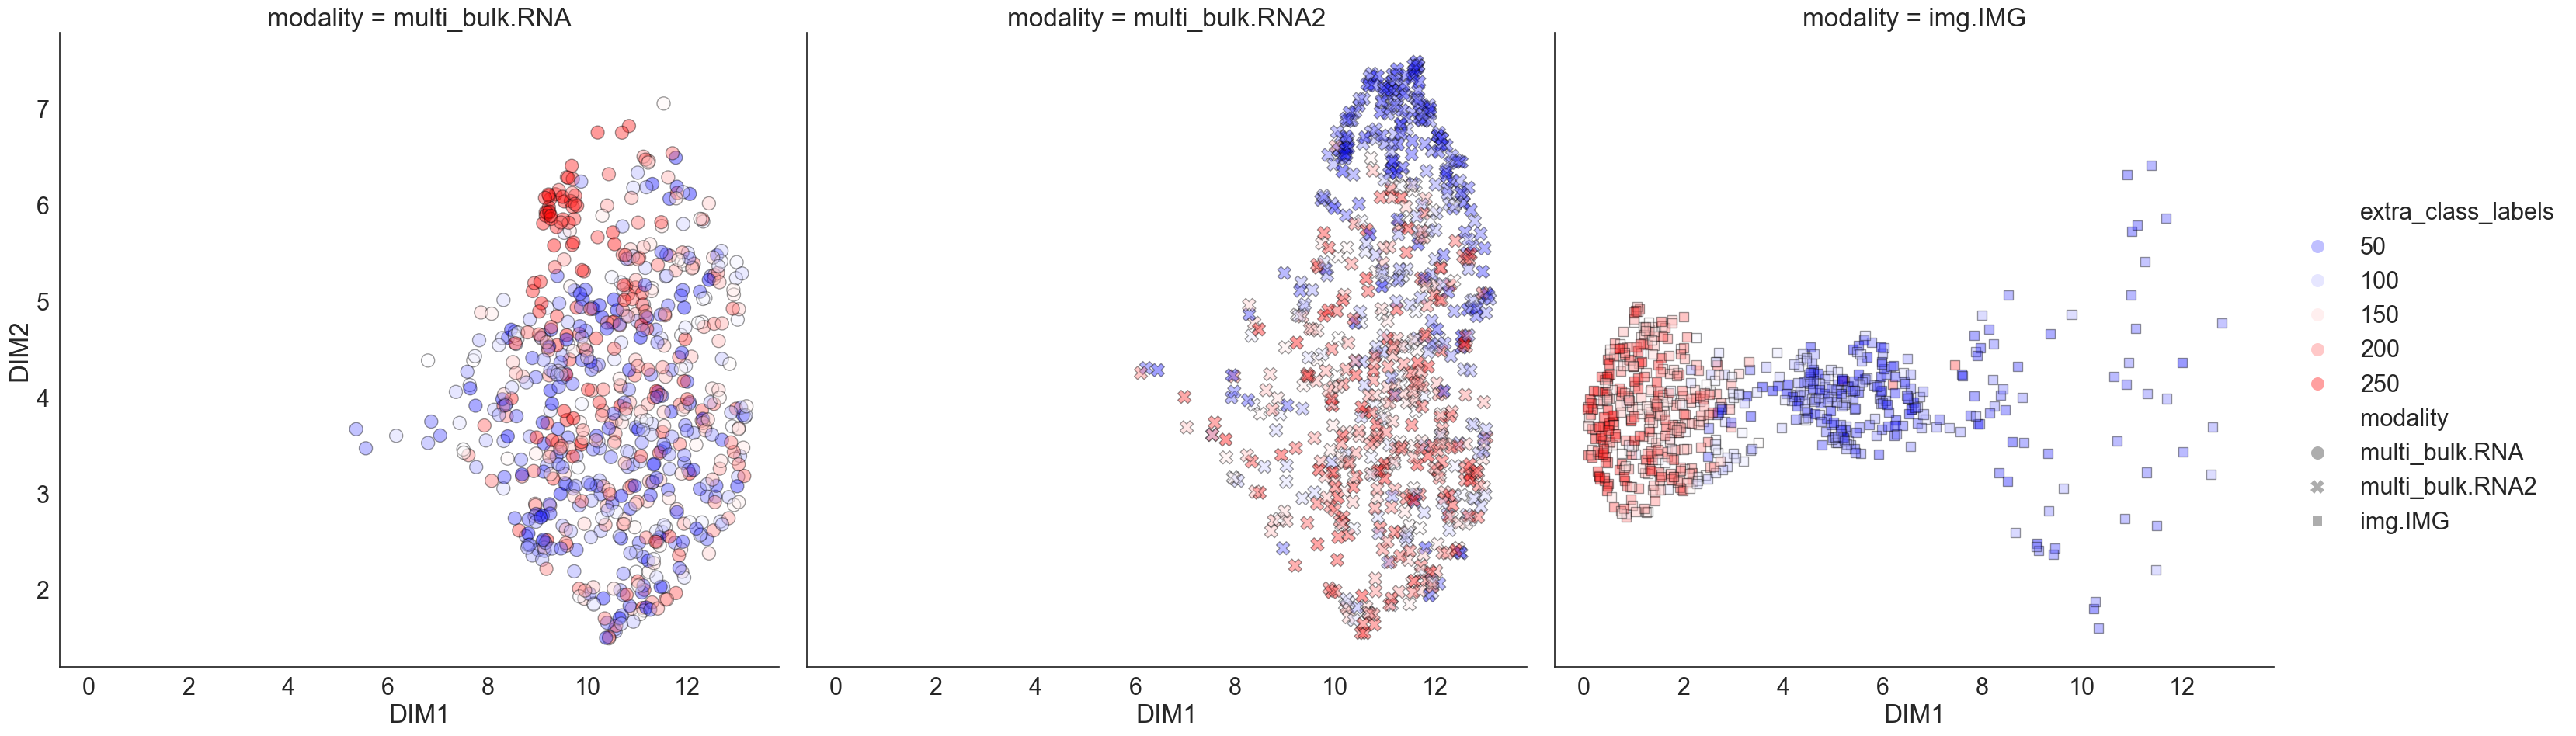

In [18]:
param = "extra_class_labels"
sns.set_theme(font_scale=2)
sns.set_style("white")

plot = plot_translate_latent(
	embedding=embedding,
	color_param=param,
	style_param="modality",
)

In [19]:
latent_data

,LatDim_0,LatDim_1,LatDim_2,LatDim_3,LatDim_4,LatDim_5,LatDim_6,LatDim_7,modality,sample_ids
0,0.062325,0.789714,1.175864,2.532598,2.449647,-0.888444,0.046169,-0.548299,multi_bulk.RNA,T_240
1,0.375615,0.532829,-0.192844,1.382143,-1.959432,0.032823,2.172921,-0.628900,multi_bulk.RNA,T_117
2,0.019346,-0.113507,0.829386,2.618888,-0.179415,-0.805279,0.273405,0.026104,multi_bulk.RNA,T_219
3,1.538954,0.222158,1.358512,1.583782,-0.291548,2.258456,-1.133078,-0.024454,multi_bulk.RNA,T_88
4,-1.050937,0.762823,1.204594,-0.923672,2.934824,-1.527262,-0.441639,0.598751,multi_bulk.RNA,T_168
...,...,...,...,...,...,...,...,...,...,...
2020,9.426431,0.243737,3.061563,-0.816092,0.109063,0.791323,-0.042028,5.491151,img.IMG,T_169
2021,6.293115,-0.147157,-0.258190,0.337085,0.119918,0.556130,-0.055418,2.208497,img.IMG,T_77
2022,7.904275,0.325428,-1.728925,-1.153707,0.605114,0.378493,-1.308132,6.126083,img.IMG,T_105
2023,9.185649,-1.343608,0.488200,0.440028,0.366540,-0.113806,-0.525910,6.912343,img.IMG,T_170


## Vis (new) Ridgeline alignment -> ridge per data modality, not grouped by clinic param

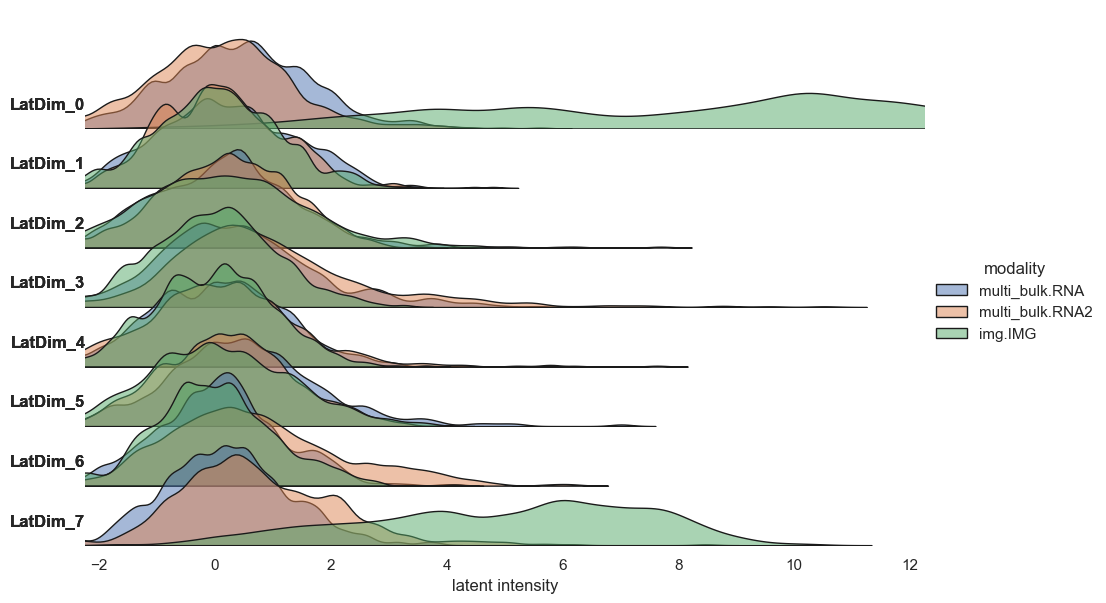

In [20]:

fig = acx.visualize.Visualizer.plot_latent_ridge(
	lat_space=latent_data.drop(columns=["sample_ids", "modality"]),
	labels= list(latent_data["modality"]),
	param="modality"
)

fig.fig

In [21]:

from typing import Optional, Union

def plot_latent_ridge_multi(
	lat_space: pd.DataFrame,
	modality: Optional[str] = None,
	labels: Optional[Union[list, pd.Series, None]] = None,
	param: Optional[Union[str, None]] = None,
) -> sns.FacetGrid:
	"""
	Creates a ridge line plot of latent space dimension where each row shows the density of a latent dimension and groups (ridges).
	ARGS:
		lat_space (pd.DataFrame): DataFrame containing the latent space intensities for samples (rows) and latent dimensions (columns)
		labels (list): List of labels for each sample. If None, all samples are considered as one group.
		param (str): Clinical parameter to create groupings and coloring of ridges. Must be a column name (str) of clin_data
	RETURNS:
		g (sns.FacetGrid): FacetGrid object containing the ridge line plot
	"""
	sns.set_theme(
		style="white", rc={"axes.facecolor": (0, 0, 0, 0)}
	)  ## Necessary to enforce overplotting

	df = pd.melt(lat_space,id_vars=modality, var_name="latent dim", value_name="latent intensity")
	# print(df)
	df["sample"] = len(lat_space.drop(columns=modality).columns) * list(lat_space.index)

	if labels is None:
		param = "all"
		labels = ["all"] * len(df)

	# print(labels[0])
	if not isinstance(labels[0], str):
		if len(np.unique(labels)) > 3:
			labels = pd.qcut(
				x=pd.Series(labels),
				q=4,
				labels=["1stQ", "2ndQ", "3rdQ", "4thQ"],
			).astype(str)
		else:
			labels = [str(x) for x in labels]

	df[param] = len(lat_space.drop(columns=modality).columns) * labels  # type: ignore

	exclude_missing_info = (df[param] == "unknown") | (df[param] == "nan")


	xmin = (
		df.loc[~exclude_missing_info, ["latent intensity", "latent dim", param]]
		.groupby([param, "latent dim"], observed=False)
		.quantile(0.05)
		.min()
	)
	xmax = (
		df.loc[~exclude_missing_info, ["latent intensity", "latent dim", param]]
		.groupby([param, "latent dim"], observed=False)
		.quantile(0.9)
		.max()
	)

	if len(np.unique(df[param])) > 8:
		cat_pal = sns.husl_palette(len(np.unique(df[param])))
	else:
		cat_pal = sns.color_palette(n_colors=len(np.unique(df[param])))

	g = sns.FacetGrid(
		df[~exclude_missing_info],
		row="latent dim",
		col=modality,
		hue=param,
		aspect=12,
		height=0.8,
		xlim=(xmin.iloc[0], xmax.iloc[0]),
		palette=cat_pal,
	)

	g.map_dataframe(
		sns.kdeplot,
		"latent intensity",
		bw_adjust=0.5,
		clip_on=True,
		fill=True,
		alpha=0.5,
		warn_singular=False,
		ec="k",
		lw=1,
	)

	def label(data, color, label, text="latent dim"):
		ax = plt.gca()
		label_text = data[text].unique()[0]
		ax.text(
			0.0,
			0.2,
			label_text,
			fontweight="bold",
			ha="right",
			va="center",
			transform=ax.transAxes,
		)

	g.map_dataframe(label, text="latent dim")

	g.set(xlim=(xmin.iloc[0], xmax.iloc[0]))
	# Set the subplots to overlap
	g.figure.subplots_adjust(hspace=-0.5)

	# Remove axes details that don't play well with overlap
	g.set_titles("")
	g.set(yticks=[], ylabel="")
	g.despine(bottom=True, left=True)

	for i, m in enumerate(df[modality].unique()):
		g.fig.get_axes()[i].set_title(m)

	g.add_legend()

	plt.close()
	return g

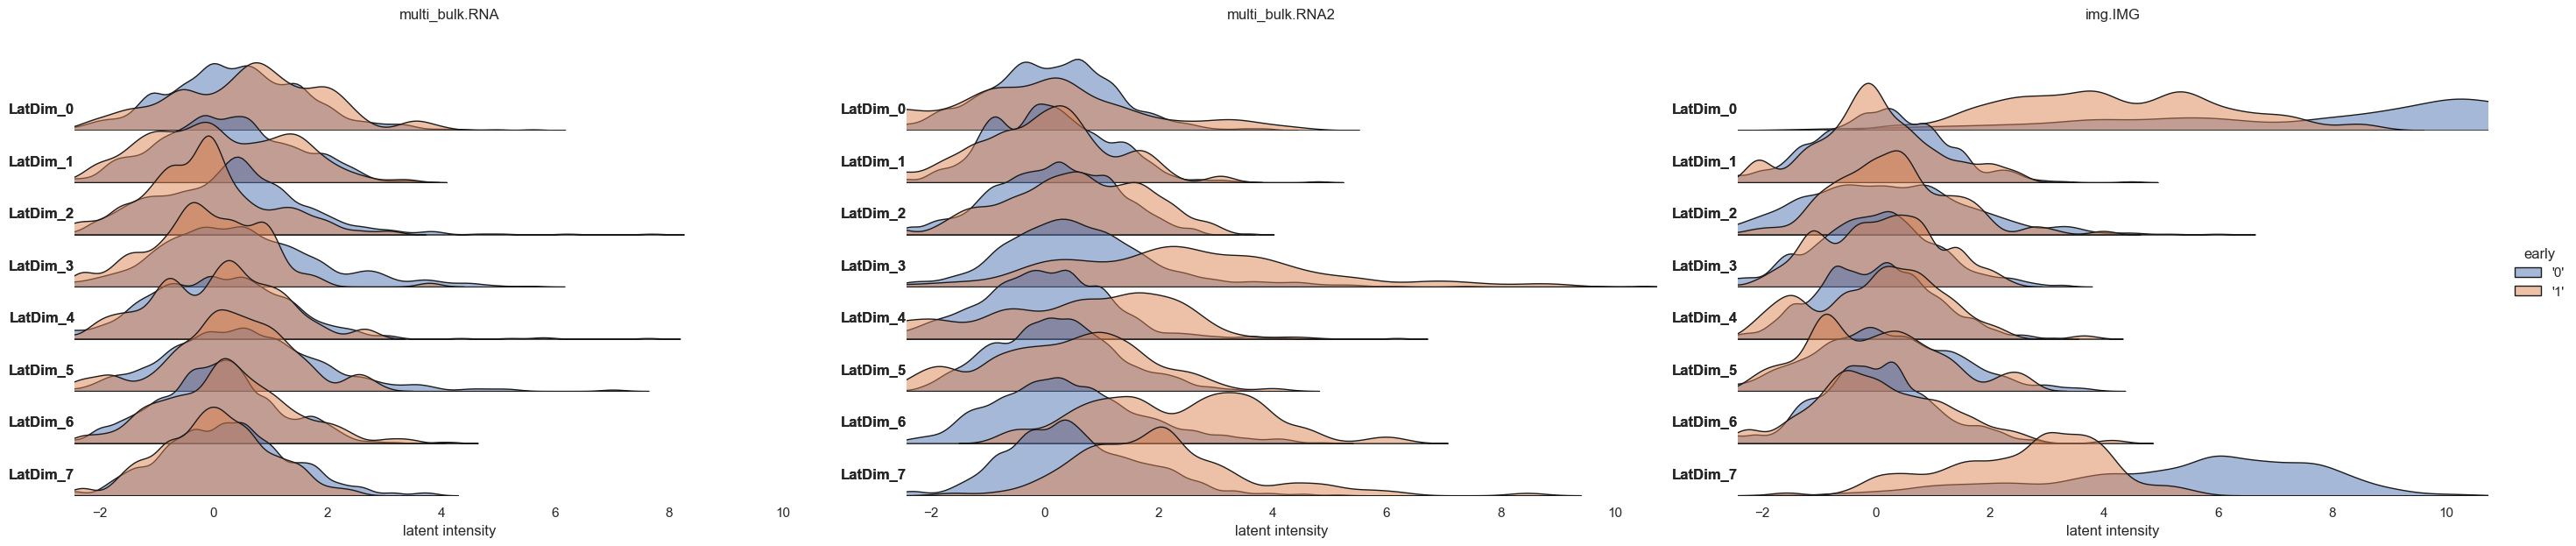

In [22]:
## Alternative show each ridgeline plot as subplots

# Merge clin_data with latent_data
latent_data_with_clin = latent_data.merge(clin_data.drop(columns=["modality"]), on="sample_ids", how="left")

param = "early"
labels = latent_data_with_clin.loc[:, param].tolist()

fig = plot_latent_ridge_multi(lat_space=latent_data.drop(columns=["sample_ids"]),
	labels=labels,
	modality="modality",
	param=param
)
fig.fig

## Vis Loss plot absolute and relative

     Epoch   Loss Term  Split  Loss Value
0        1  total_loss  train   68.550300
1        2  total_loss  train   62.213257
2        3  total_loss  train   59.108326
3        4  total_loss  train   57.355900
4        5  total_loss  train   54.865769
..     ...         ...    ...         ...
215      1  total_loss  valid   50.001694
216      2  total_loss  valid   47.956933
217      3  total_loss  valid   42.914910
218      4  total_loss  valid   42.436281
219      5  total_loss  valid   42.776210

[70 rows x 4 columns]


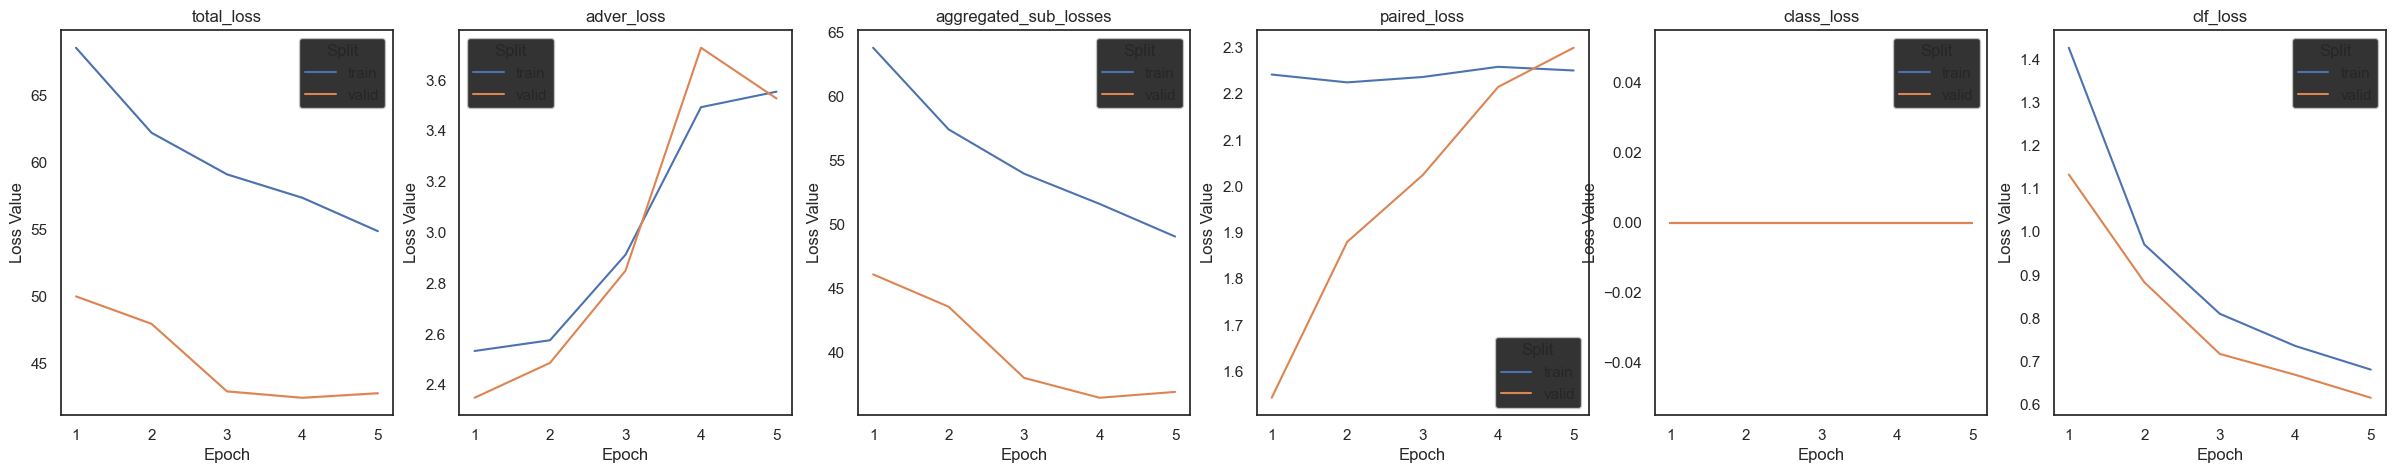

In [23]:
loss_df_melt = acx.visualize.Visualizer.make_loss_format(result=xmodalix.result, config=xmodalix.config)


# Filter loss terms which are specific for each modality VAE
# Plot only combined loss terms as in old autoencodix framework
loss_df_melt = loss_df_melt[
    ~ loss_df_melt["Loss Term"].str.startswith(
        tuple(xmodalix.result.datasets.train.datasets.keys())
    )
]

print(loss_df_melt)


fig_loss = acx.visualize.Visualizer.make_loss_plot(
            df_plot=loss_df_melt, plot_type="absolute"
        )

fig_loss

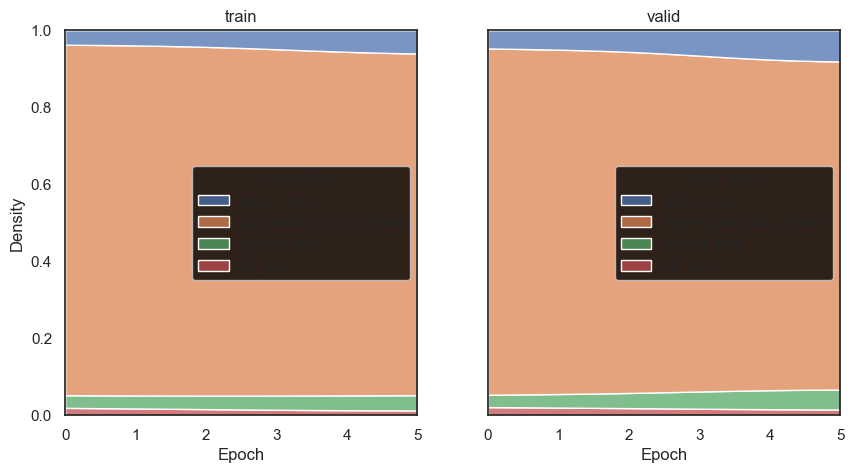

In [24]:
fig_loss_relative = acx.visualize.Visualizer.make_loss_plot(
			df_plot=loss_df_melt, plot_type="relative"
		)

fig_loss_relative

## Vis translate Grid (image case)

In [25]:
param = "early"
n_sample_per_class = 3

# Get n samples per class
# Get metadata for test split and img.IMG modality
meta = xmodalix.result.datasets.test.datasets['img.IMG'].metadata

# Get possible class values
class_values = meta[param].unique()

# Build dictionary of sample_ids per class value (max n_sample_per_class per class)
sample_per_class = {
	val: meta[meta[param] == val].sample(
		n=min(n_sample_per_class, (meta[param] == val).sum()), random_state=42
	).index.tolist()
	for val in class_values
}
sample_per_class

{"'1'": ['T_11', 'T_13', 'T_32'], "'0'": ['T_196', 'T_195', 'T_205']}

In [26]:
meta

,img_paths,extra_class_labels,early
sample_ids,,,
T_32,ALY-2_SYS721_t32.tif,32,'1'
T_115,ALY-2_SYS721_t115.tif,115,'0'
T_25,ALY-2_SYS721_t25.tif,25,'1'
T_116,ALY-2_SYS721_t116.tif,116,'0'
T_30,ALY-2_SYS721_t30.tif,30,'1'
T_102,ALY-2_SYS721_t102.tif,102,'0'
T_34,ALY-2_SYS721_t34.tif,34,'1'
T_21,ALY-2_SYS721_t21.tif,21,'1'
T_139,ALY-2_SYS721_t139.tif,139,'0'


In [27]:
print(len(xmodalix.result.datasets.test.datasets["img.IMG"].sample_ids))
len(set(xmodalix.result.datasets.test.datasets["img.IMG"].sample_ids) & set(xmodalix.result.datasets.test.datasets["img.IMG"].metadata.index))

52


52

In [28]:
(xmodalix.result.datasets.train.datasets["multi_bulk.RNA"].metadata.index)

Index(['T_118', 'T_214', 'T_243', 'T_160', 'T_82', 'T_179', 'T_198', 'T_210',
       'T_226', 'T_247',
       ...
       'T_44', 'T_156', 'T_41', 'T_137', 'T_128', 'T_73', 'T_212', 'T_244',
       'T_199', 'T_58'],
      dtype='object', length=182)

In [29]:
len(xmodalix.result.datasets.test.datasets["img.IMG"].metadata)

52

In [30]:
sample_ids_list = xmodalix.result.datasets.test.datasets['img.IMG'].sample_ids

sample_idx_per_class = dict()

for class_value in sample_per_class:
	# Get sample ids for the current class value
	sids = sample_per_class[class_value]
	# Get indices of these sample ids in the sample_ids_list
	indices = [sample_ids_list.index(sid) for sid in sids if sid in sample_ids_list]
	# Store the indices in the dictionary
	sample_idx_per_class[class_value] = indices

sample_idx_per_class

## PROBLEM: metadata and test.datasets do not have the same sample_ids but should have

{"'1'": [45, 41, 0], "'0'": [27, 24, 23]}

In [31]:
xmodalix.result.reconstructions.get(epoch=-1, split="test")["img.IMG"]

array([[[[0.44949433, 0.27136913, 0.35285428, ..., 0.25061417,
          0.3036799 , 0.37720773],
         [0.41325635, 0.22135848, 0.2243021 , ..., 0.23616189,
          0.20208035, 0.32439235],
         [0.34437412, 0.20561987, 0.2226788 , ..., 0.18711399,
          0.15329307, 0.30082554],
         ...,
         [0.43901926, 0.22124611, 0.27065605, ..., 0.26031944,
          0.28132218, 0.34489596],
         [0.3002325 , 0.2340671 , 0.22832984, ..., 0.2175333 ,
          0.16713108, 0.33462387],
         [0.47410172, 0.3094373 , 0.43712112, ..., 0.33992043,
          0.3844217 , 0.38545635]]],


       [[[0.44949496, 0.27131706, 0.35299456, ..., 0.25057092,
          0.30351818, 0.37704882],
         [0.41256914, 0.22147031, 0.22276135, ..., 0.23645414,
          0.20260611, 0.3236068 ],
         [0.34412822, 0.20467941, 0.22147499, ..., 0.18678099,
          0.15268195, 0.30013737],
         ...,
         [0.43888742, 0.22077496, 0.27113232, ..., 0.26151645,
          0.2807028 , 0

### Flexible Prediction
We train the Xmodalix with multiple data modalities, out of all these modalities, we can build any pair for translation byt passing the keys (as defined in your config or datapackage) to the predict method like:

In [32]:
result2 = xmodalix.predict(from_key="IMG", to_key="IMG")

[np.str_('T_102'), np.str_('T_165'), np.str_('T_4'), np.str_('T_115'), np.str_('T_205'), np.str_('T_127'), np.str_('T_66'), np.str_('T_203'), np.str_('T_9'), np.str_('T_253'), np.str_('T_123'), np.str_('T_30'), np.str_('T_196'), np.str_('T_72'), np.str_('T_32'), np.str_('T_246'), np.str_('T_21'), np.str_('T_75'), np.str_('T_204'), np.str_('T_151'), np.str_('T_36'), np.str_('T_40'), np.str_('T_99'), np.str_('T_145'), np.str_('T_62'), np.str_('T_255'), np.str_('T_213'), np.str_('T_216'), np.str_('T_13'), np.str_('T_176'), np.str_('T_34'), np.str_('T_191'), np.str_('T_134'), np.str_('T_25'), np.str_('T_225'), np.str_('T_242'), np.str_('T_195'), np.str_('T_201'), np.str_('T_11'), np.str_('T_86'), np.str_('T_91'), np.str_('T_92'), np.str_('T_133'), np.str_('T_218')]
Prediction complete.
Processing latent space results into a single AnnData object...
Identified source modality for latent space: 'multi_bulk.RNA'
  - Added 279 source feature IDs to .uns
Finished processing latent results.


### Inspecting losses
We save all losses in our result object, see the keys here:

In [33]:
result.sub_losses.keys()

dict_keys(['total_loss', 'adver_loss', 'aggregated_sub_losses', 'paired_loss', 'class_loss', 'multi_bulk.RNA.recon_loss', 'multi_bulk.RNA.var_loss', 'multi_bulk.RNA.anneal_factor', 'multi_bulk.RNA.effective_beta_factor', 'multi_bulk.RNA.loss', 'multi_bulk.RNA2.recon_loss', 'multi_bulk.RNA2.var_loss', 'multi_bulk.RNA2.anneal_factor', 'multi_bulk.RNA2.effective_beta_factor', 'multi_bulk.RNA2.loss', 'img.IMG.recon_loss', 'img.IMG.var_loss', 'img.IMG.anneal_factor', 'img.IMG.effective_beta_factor', 'img.IMG.loss', 'clf_loss'])

After selecting a subloss, this works like a standard TrainingDynamic

In [34]:
result.sub_losses.get("adver_loss")

TrainingDynamics()

### Visualizing a sample output
Note this is shown with only one epoch training, I've seen good results for 20 epochs of pretraining img and 30 epochs of normal training

In [35]:
img = result.reconstructions.get(split="test", epoch=-1)

In [36]:
img = img["translation"]

In [37]:
img.shape

(115, 1, 64, 64)

In [38]:
sample_img = img[0, :, :, :].squeeze()
sample_img.shape

(64, 64)

In [39]:
sample_img.max()

np.float32(0.47394648)

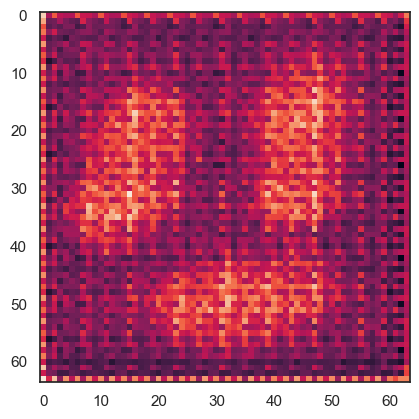

In [40]:
import matplotlib.pyplot as plt
plt.imshow(sample_img)

### Getting Info about pretraining
The pretraining is saved in sub_results in the result object

In [41]:
sub_res = result.sub_results
sub_res

{'multi_bulk.RNA': None,
 'multi_bulk.RNA2': None,
 'img.IMG': None,
 'pretrain.img.IMG': Result Object Public Attributes:
 ------------------------------
 latentspaces: TrainingDynamics object
 sample_ids: TrainingDynamics object
 reconstructions: TrainingDynamics object
 mus: TrainingDynamics object
 sigmas: TrainingDynamics object
 losses: TrainingDynamics object
 sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics(), 'var_loss': TrainingDynamics(), 'anneal_factor': TrainingDynamics(), 'effective_beta_factor': TrainingDynamics()})
 preprocessed_data: Tensor of shape (0,)
 model: ImageVAEArchitecture
 model_checkpoints: TrainingDynamics object
 datasets: DatasetContainer(train=None, valid=None, test=None)
 new_datasets: DatasetContainer(train=None, valid=None, test=None)
 adata_latent: AnnData object with n_obs × n_vars = 0 × 0
 final_reconstruction: None
 sub_results: None
 sub_reconstructions: None
 embedding_evaluation: Empty DataFrame
 Columns: []
 Index: []}

## Xmodal_loss Visualization
Vibe coded provisory loss visualization

In [42]:
result.sub_losses.keys()
result.sub_losses.get("img.IMG.var_loss").get()


{0: {'train': array(17.69915009), 'valid': array(3.52645345)},
 1: {'train': array(17.66782867), 'valid': array(7.39468892)},
 2: {'train': array(17.6854515), 'valid': array(11.93364401)},
 3: {'train': array(17.6809624), 'valid': array(15.56529979)},
 4: {'train': array(17.68402302), 'valid': array(17.57744799)}}

Generating plots from mock result object...


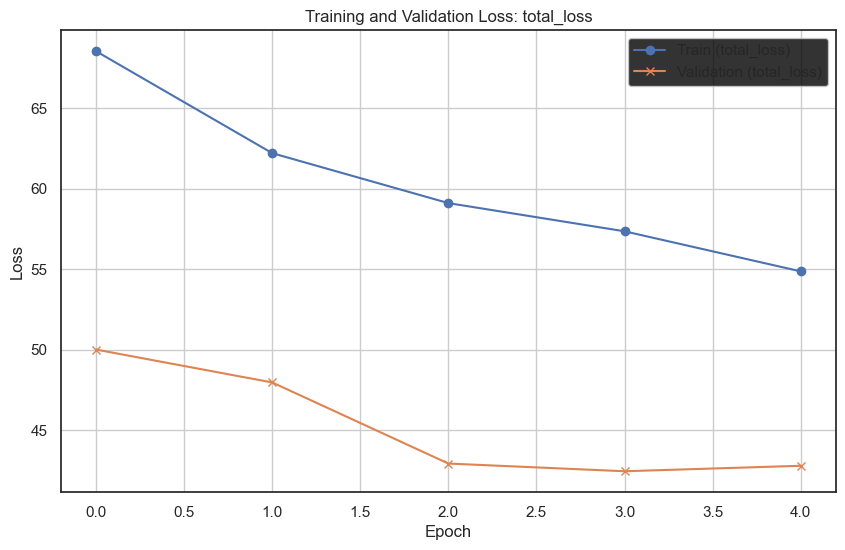

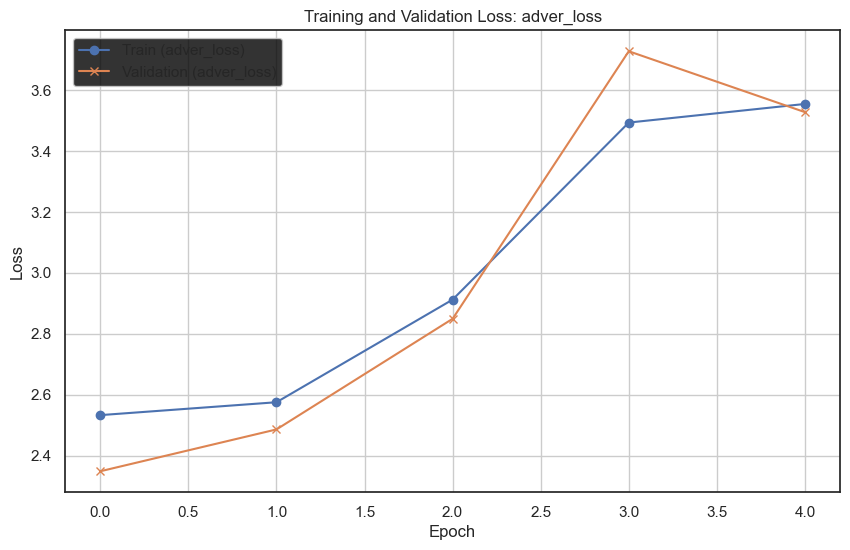

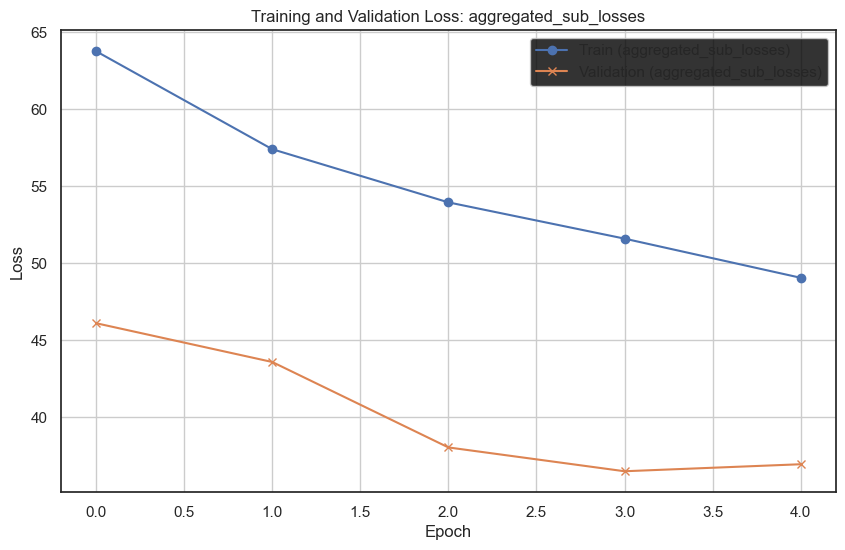

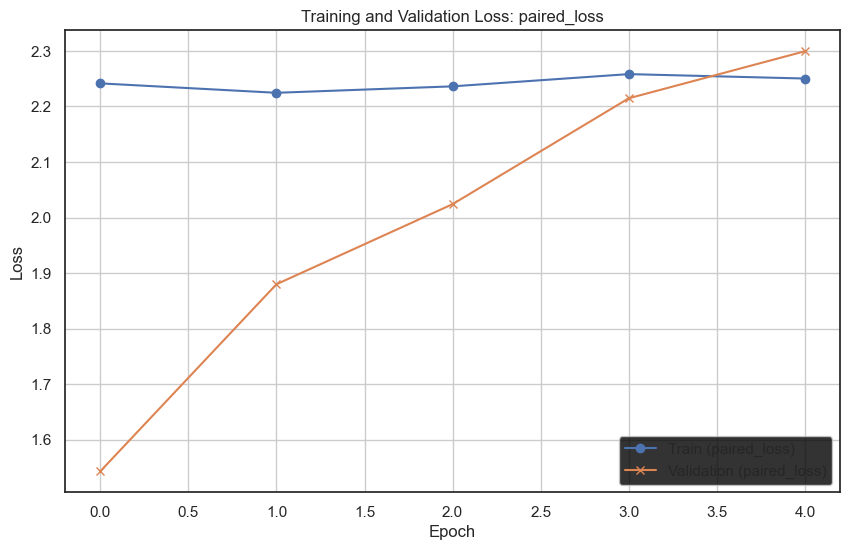

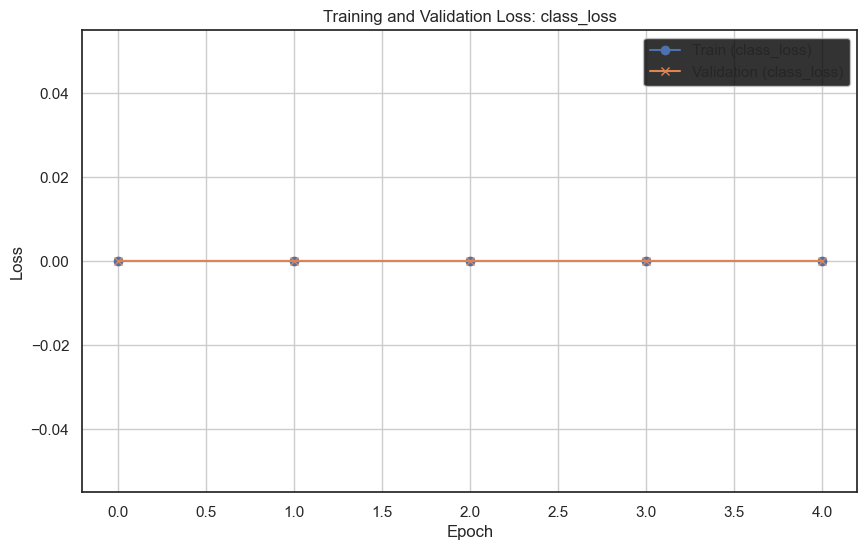

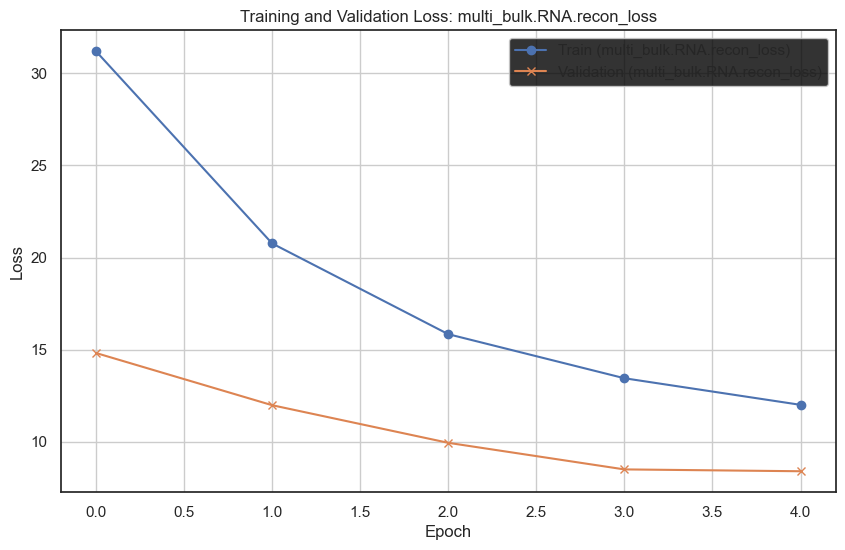

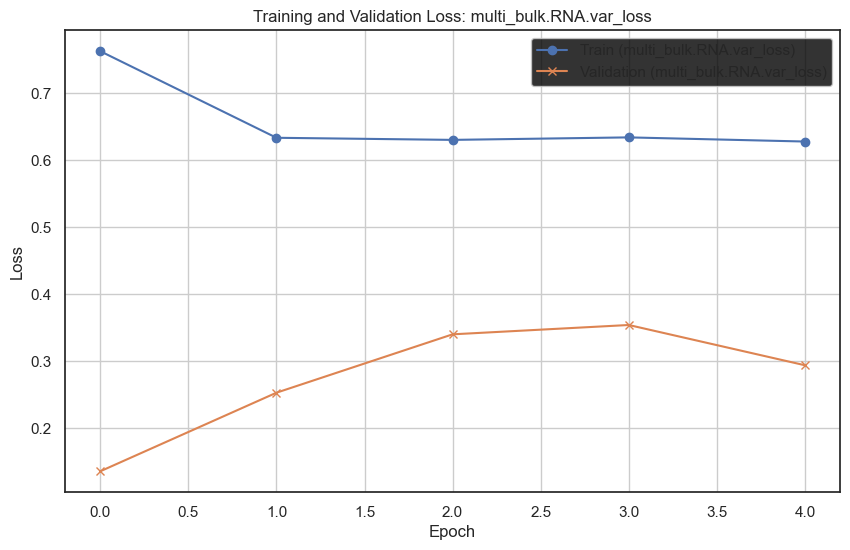

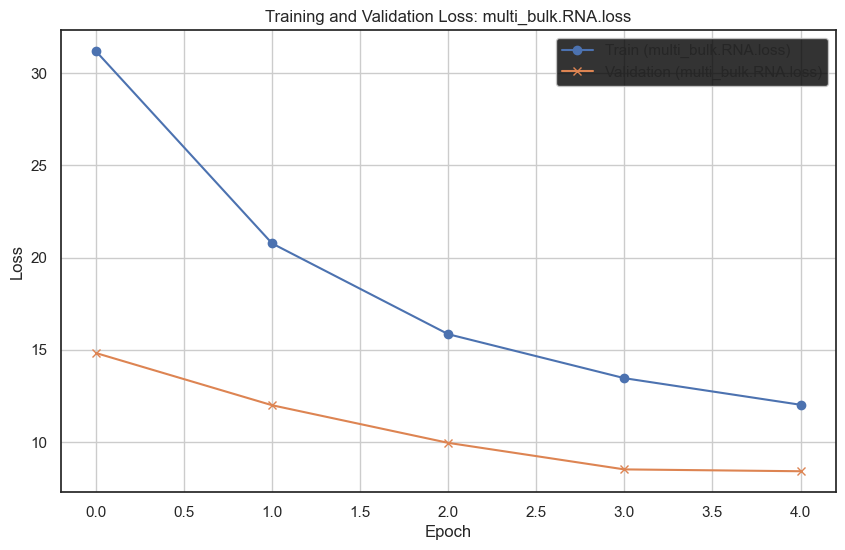

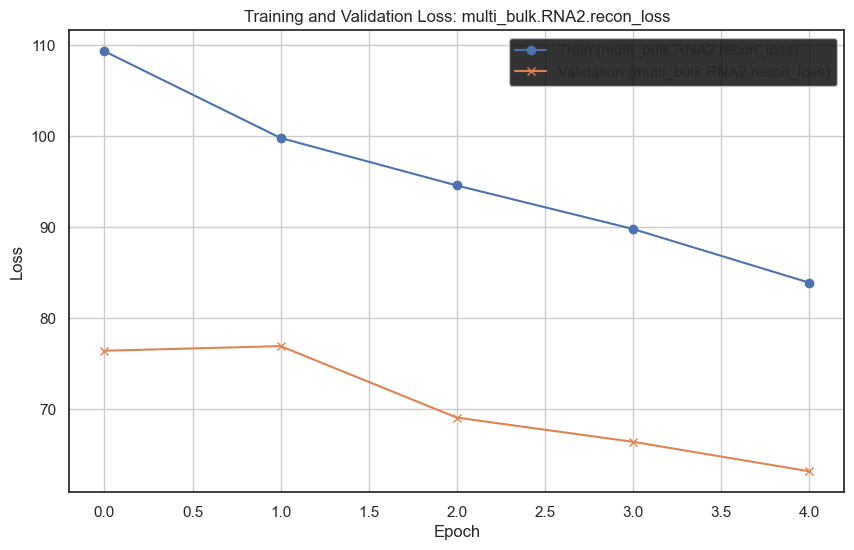

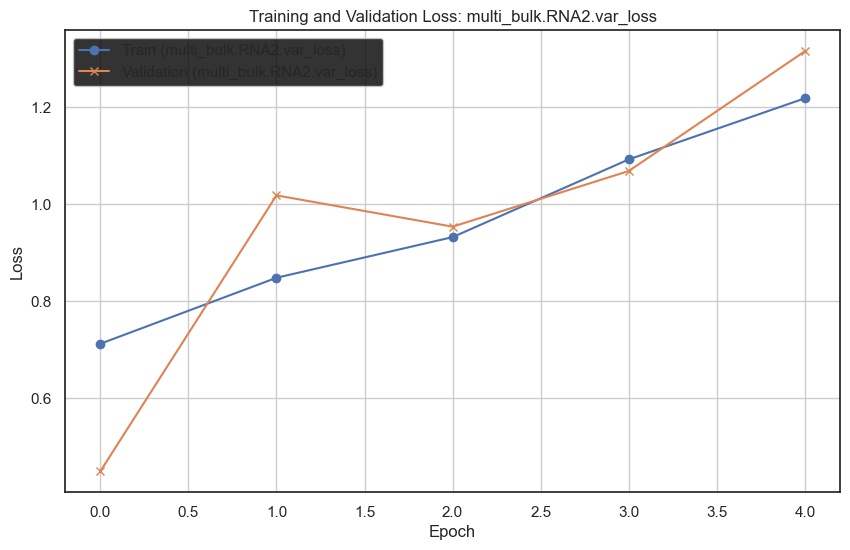

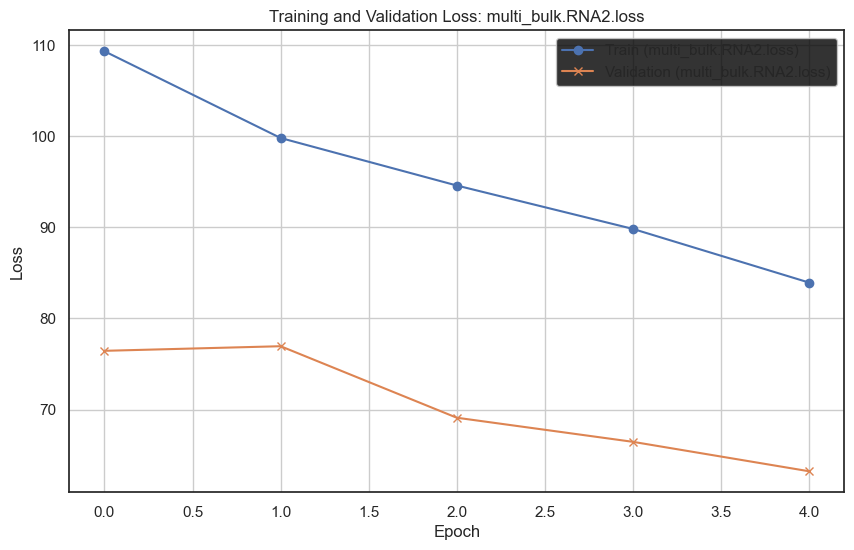

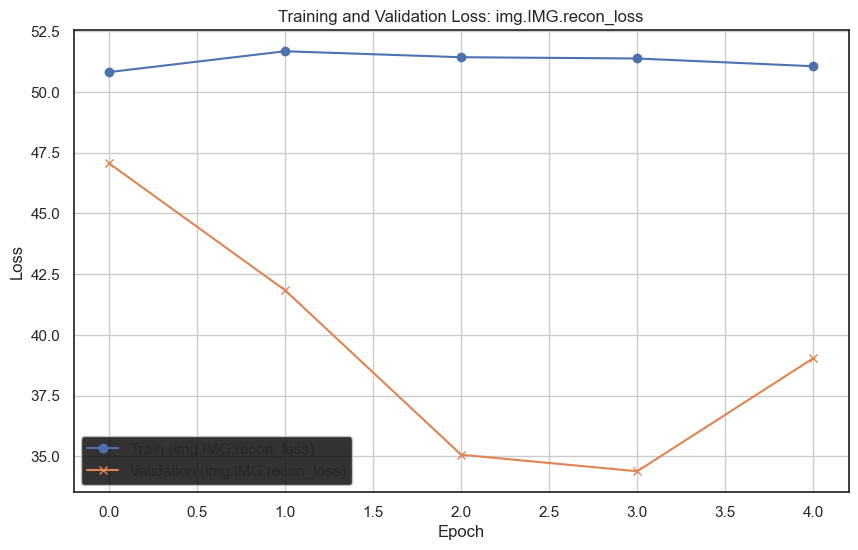

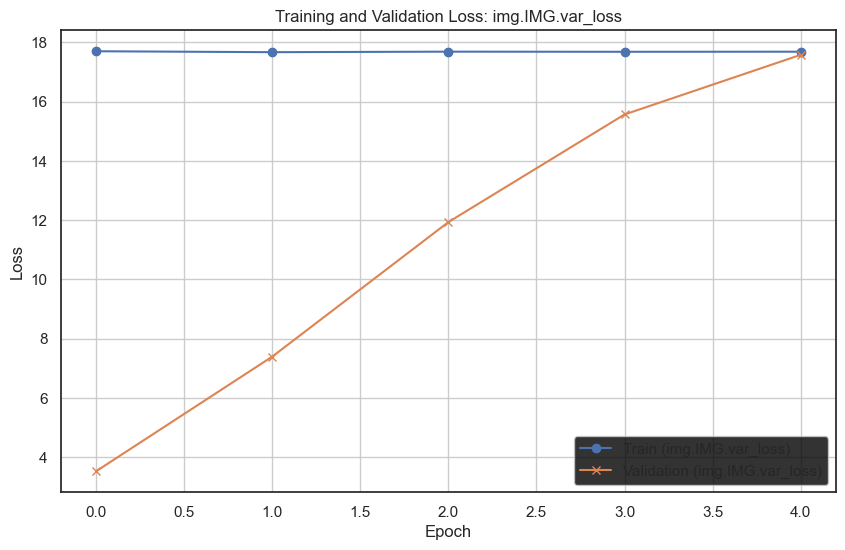

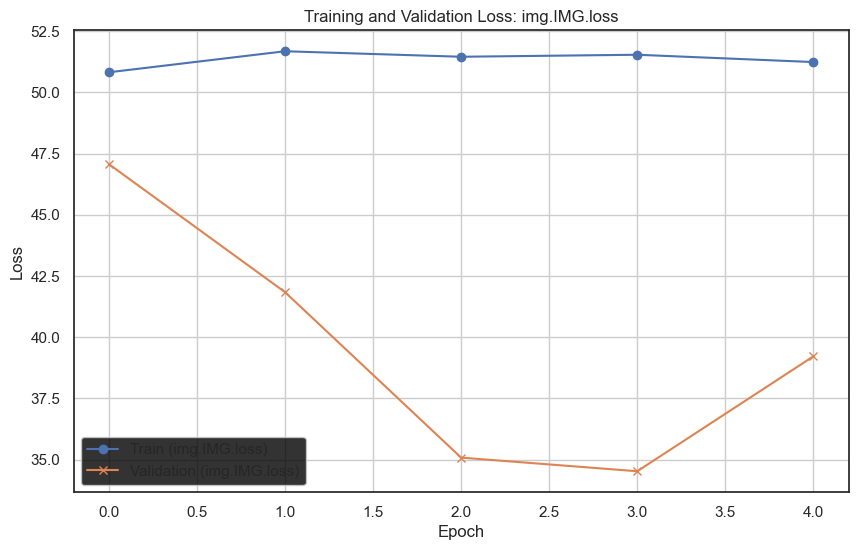

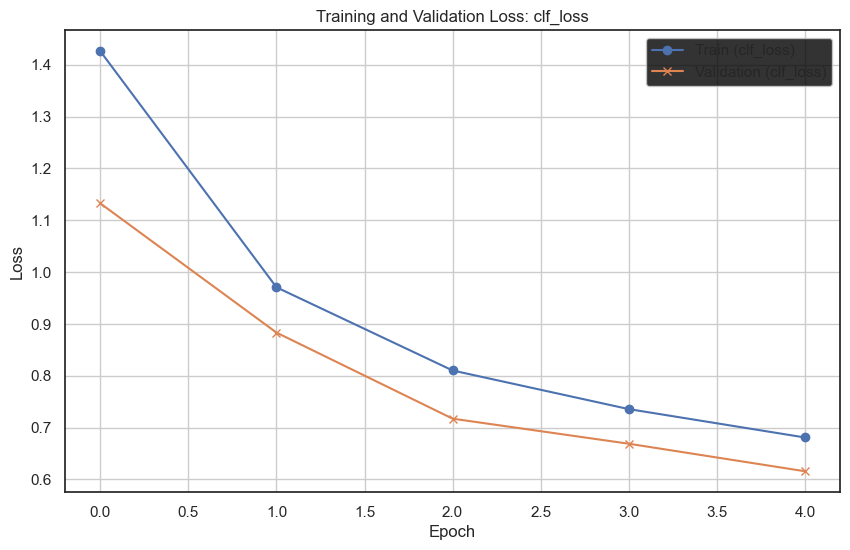

In [43]:
import matplotlib.pyplot as plt


def plot_losses(result):
    """
    Generates and displays plots for all relevant losses from a Result object.

    Args:
        result: Your custom result object containing the sub_losses attribute.
    """
    if not hasattr(result, "sub_losses"):
        print(
            "Error: The provided result object does not have a 'sub_losses' attribute."
        )
        return

    # 1. Get all loss keys and filter out the factors
    all_loss_keys = result.sub_losses.keys()
    keys_to_plot = [key for key in all_loss_keys if not key.endswith("_factor")]

    if not keys_to_plot:
        print("No valid loss keys found to plot.")
        return

    # 2. Iterate through each loss and create a plot
    for loss_name in keys_to_plot:
        try:
            # Retrieve the nested dictionary for the current loss
            loss_data = result.sub_losses.get(loss_name).get()

            # 3. Unpack the data into lists for plotting
            epochs = sorted(loss_data.keys())
            train_losses = [loss_data[epoch]["train"] for epoch in epochs]

            # Check if validation data exists before trying to plot it
            has_valid_data = all("valid" in loss_data[epoch] for epoch in epochs)
            if has_valid_data:
                valid_losses = [loss_data[epoch]["valid"] for epoch in epochs]

            # 4. Create the plot
            plt.figure(figsize=(10, 6))
            plt.plot(epochs, train_losses, "o-", label=f"Train ({loss_name})")
            if has_valid_data:
                plt.plot(epochs, valid_losses, "x-", label=f"Validation ({loss_name})")

            plt.title(f"Training and Validation Loss: {loss_name}")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid(True)
            plt.show()

        except (AttributeError, TypeError, KeyError) as e:
            print(f"Could not plot '{loss_name}'. Error retrieving data: {e}")


# This is a mock setup to demonstrate how to use the function.
print("Generating plots from mock result object...")
plot_losses(result)

## Imagix
If we want to use a standard image vae, we can use the Imagix pipeline. Note that only one image dataset is allowed here
**NOTE**:
set the datacase in config to DataCase.IMG_TO_IMG

In [44]:
import autoencodix as acx
from autoencodix.configs.default_config import (
    DefaultConfig,
    DataConfig,
    DataCase,
    DataInfo,
)
import os

IMGROOT = os.path.join("data/images/ALY-2_SYS721/")
IMGMAPPING = os.path.join("data/ALY-2_SYS721_mappings.txt")
NUMFILE = os.path.join("data/AM3_NO2_raw_cell.tsv")

img_config2 = DefaultConfig(
    data_case=DataCase.IMG_TO_IMG,
    checkpoint_interval=10,
	loss_reduction = "sum",
    epochs=100,
	beta = 0.1,
	learning_rate=0.001,
	latent_dim=16,
    batch_size=32,
    data_config=DataConfig(
        data_info={
            "IMG": DataInfo(
                file_path=IMGROOT,
				scaling="MINMAX",
                data_type="IMG",
            ),
            "ANNO": DataInfo(
                file_path=IMGMAPPING,
                data_type="ANNOTATION",
            ),
        },
    ),
)

imagix = acx.Imagix(config=img_config2)
imagix.preprocess()
imagix.fit()

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/configs/default_config.py:479: UserWarning: Could not determine data_case: No numeric datasets found in data_info
  warnings.warn(f"Could not determine data_case: {str(e)}")
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_imgreader.py:251: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  annotation = pd.read_csv(anno_file, sep=sep)


preprocessing
Checking data type: IMG
Found image type in config
current data info: file_path='data/images/ALY-2_SYS721/' data_type='IMG' scaling='MINMAX' filtering='VAR' sep=None extra_anno_file=None is_single_cell=False min_cells=0.05 min_genes=0.02 selected_layers=['X'] is_X=False normalize_counts=True log_transform=True k_filter=20 img_root=None img_width_resize=64 img_height_resize=64 translate_direction=None pretrain_epochs=0
Checking data type: ANNO
Given image size is possible, rescaling images to: 64x64
reading annotation file: data/ALY-2_SYS721_mappings.txt
Successfully loaded 260 images for IMG
--- Running Pairing-Aware Split ---
Identified 260 fully paired samples across all modalities.
Identified 0 samples present in at least one, but not all, modalities.
Successfully generated synchronized indices for all modalities.
Converting 182 images to torch.float32 tensors...
Converting 52 images to torch.float32 tensors...
Converting 26 images to torch.float32 tensors...
Epoch 1 -

In [45]:
imagix.predict()

Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics(), 'var_loss': TrainingDynamics(), 'anneal_factor': TrainingDynamics(), 'effective_beta_factor': TrainingDynamics()})
preprocessed_data: Tensor of shape (0,)
model: ImageVAEArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=<autoencodix.data._image_dataset.ImageDataset object at 0x4065fe0e0>, valid=<autoencodix.data._image_dataset.ImageDataset object at 0x40319c070>, test=<autoencodix.data._image_dataset.ImageDataset object at 0x40319c040>)
new_datasets: DatasetContainer(train=None, valid=None, test=None)
adata_latent: AnnData object with n_obs × n_vars = 52 × 16
    uns: 'var_names'
final_reconstruction: <autoencodix

In [46]:
r2 = imagix.result
r2.final_reconstruction
sample_img = r2.final_reconstruction.data[0, :, :, :]
sample_img = sample_img.squeeze()

In [47]:
sample_img

tensor([[0.9787, 0.9974, 0.9976,  ..., 0.9906, 0.9975, 0.9719],
        [0.9919, 0.9987, 0.9989,  ..., 0.9979, 0.9983, 0.9959],
        [0.9902, 0.9984, 0.9993,  ..., 0.9980, 0.9988, 0.9957],
        ...,
        [0.9927, 0.9985, 0.9988,  ..., 0.9987, 0.9976, 0.9979],
        [0.9906, 0.9988, 0.9988,  ..., 0.9993, 0.9976, 0.9868],
        [0.9573, 0.9848, 0.9962,  ..., 0.9906, 0.9928, 0.9293]])

In [48]:
sample_img = r2.reconstructions.get(split="test")
sample_img = sample_img[0,0,:,:,:]
sample_img = sample_img.squeeze()
sample_img.shape

(64, 64)

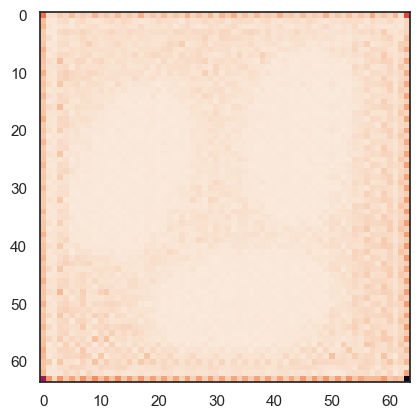

In [49]:
import matplotlib.pyplot as plt

plt.imshow(sample_img)